In [ ]:
# default_exp fastai-sequence

# Action Recognition using Fastai

> Ref. [3D Resnet for NIfTI images](https://gist.github.com/jcreinhold/78943cdeca1c5fca4a5af5d066bd8a8d)

In [ ]:
import cv2
from PIL import Image

import fastai
from fastai.vision import *
from fastai.vision.transform import *
import torchvision.transforms as transforms

from fastai.metrics import error_rate, accuracy

from actions_in_videos.dataset_ucf101 import UCF101
from actions_in_videos.avi import AVI

Reload packages where content for package development

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
print(f'fastai version: {fastai.__version__}')
print(f'pytorch version: {torch.__version__}')
print('python version: {}.{}.{}'.format(sys.version_info.major, sys.version_info.minor, sys.version_info.micro))
#print(f'torchvision version: {torchvision.__version__}')

fastai version: 1.0.60
pytorch version: 1.4.0
python version: 3.7.4


Check GPU

In [ ]:
!nvidia-smi

Sun Mar  1 12:02:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    31W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Custom DataSets in Fastai
> ref. https://docs.fast.ai/basic_data.html#DataBunch  
https://docs.fast.ai/tutorial.itemlist.html  
https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4  

In [ ]:
class SingleFrameList(ItemList): 
    """
       Subclass ImageList to use our own image opening function
       This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    # _bunch
    # _processor
    _label_cls=None  # If set to one, fastai selects one class that should fit.
    def __init__(self, items, **kwargs):
        super().__init__(items, **kwargs)        
      
    def open(self, fn:PathOrStr)->Image:
        avi = AVI(fn, verbose=True, img_type=np.float32)
        x = avi.getRandomFrame()        
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        x = pil2tensor(x,np.float32)
        x.div_(255)            
        return vision.Image(x)    
    
    def get(self, i):
        "Defines how to construct an ItemBase from the data in the ItemList.items array"
        fn = super().get(i)
        res = self.open(fn)
        return res
    
    def reconstruct(self, t:Tensor): 
        return vision.Image(t.float().clamp(min=0,max=1))
    
    @classmethod
    def from_folder(cls, path, **kwargs):
        res = super().from_folder(path, **kwargs)
        res.path = path
        return res
    
    def split_by_files(self, names):
        return self.split_by_valid_func(lambda o: any(o.name in vn for vn in names))
    
    def split_by_fname_file(self, fname, path=None, **kwargs):        
        "Split the data by using the names in `fname` for the validation set. `path` will override `self.path`."        
        path = Path(ifnone(path, self.path))
        relative_valid_names = loadtxt_str(path/fname)
        valid_names = [str(Path(self.path).joinpath(Path(fn))) for fn in relative_valid_names]        
        return self.split_by_files(valid_names)        
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [ ]:
data = (SingleFrameList.from_folder('../data/UCF101/UCF-101/'))

In [ ]:
data.items

array([PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g10_c04.avi'),
       PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g17_c01.avi'),
       PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g06_c04.avi'),
       PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g05_c02.avi'), ...,
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g15_c01.avi'),
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g05_c02.avi'),
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g04_c03.avi'),
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g24_c02.avi')], dtype=object)

In [ ]:
def get_y_func(o):
    if str(o.parents[0]).split('/')[-1] == 'models':
        print(str(o.parents[0]).split('/')[-1]) 
        import pdb
        pdb.set_trace()
    return str(o.parents[0]).split('/')[-1]

get_y = lambda o:str(o.parents[0]).split('/')[-1]

tfms = get_transforms(do_flip=True, flip_vert=False)

data_path = '../data/UCF101/UCF-101/'

In [ ]:
data = (SingleFrameList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
        .split_by_fname_file(fname='testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/')             #How to split in train/valid? -> use the folders
        .label_from_func(get_y_func)         # How to label
#        .add_test_folder()                  # Optionally add a test set (here default name is test)
        .transform(tfms, size=224)           # Data augmentation? -> use tfms with a size of 224
        .databunch())    

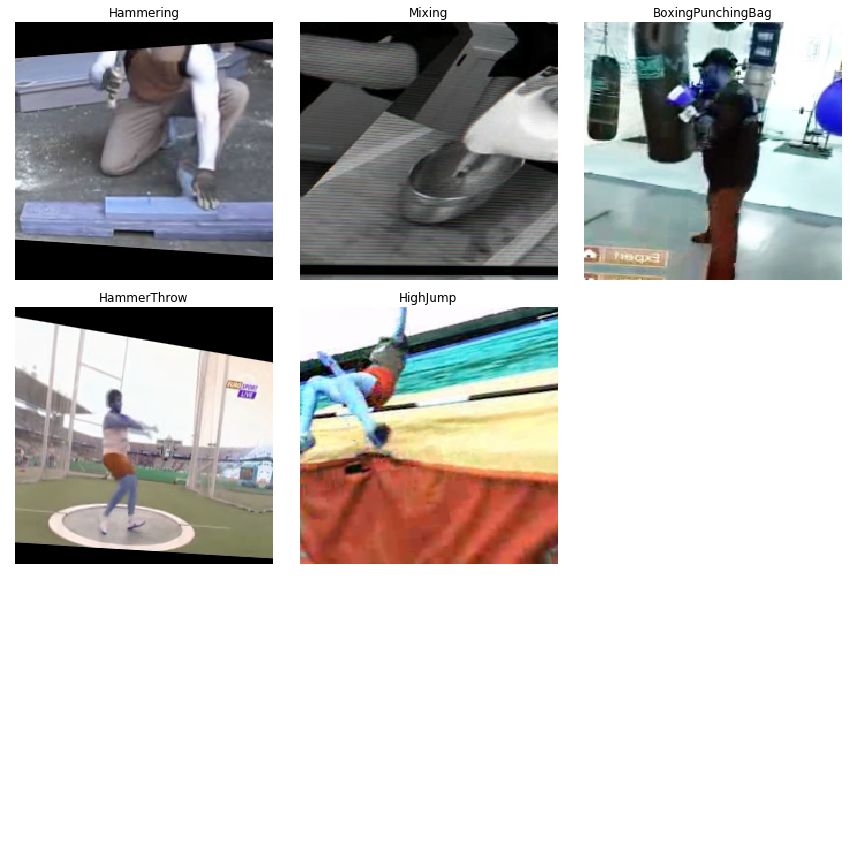

In [ ]:
data.show_batch()

In [ ]:
len(data.train_ds.y.classes)

101

## Using a default fastai cnn learner

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [ ]:
learn.path

PosixPath('../data/UCF101/UCF-101')

In [ ]:
learn.model_dir = '../../../actions_in_videos/models'

## Training

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


ERROR in file: ../data/UCF101/UCF-101/VolleyballSpiking/v_VolleyballSpiking_g22_c01.avi, frame-index: 112.
ERROR in file: ../data/UCF101/UCF-101/VolleyballSpiking/v_VolleyballSpiking_g22_c01.avi, frame_index: 112. Retrying with different random frame number.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


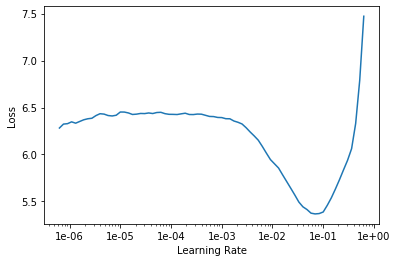

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.992738,1.608017,0.422680,0.577320,02:04


In [ ]:
learn.save('fastai-1')

In [ ]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.256399,2.197023,0.507005,0.492995,01:33
1,1.647365,2.097632,0.501983,0.498017,01:32
2,1.126010,1.471943,0.382501,0.617499,01:32
3,0.723084,1.211582,0.324874,0.675126,01:31
4,0.548556,1.156874,0.314036,0.685964,01:32


ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g16_c04.avi, frame-index: 93.
ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g16_c04.avi, frame_index: 93. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g18_c05.avi, frame-index: 145.
ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g18_c05.avi, frame_index: 145. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g24_c07.avi, frame-index: 299.
ERROR in file: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g24_c07.avi, frame_index: 299. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/BaseballPitch/v_BaseballPitch_g09_c06.avi, frame-index: 67.
ERROR in file: ../data/UCF101/UCF-101/BaseballPitch/v_BaseballPitch_g09_c06.avi, frame_index: 67. Retrying with different random frame number.


In [ ]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.639716,1.651086,0.401269,0.598731,01:31
1,1.099409,1.767185,0.437483,0.562517,01:31
2,0.843793,1.428163,0.358446,0.641554,01:31
3,0.548297,1.214603,0.303463,0.696537,01:30
4,0.419759,1.161094,0.295004,0.704996,01:30


ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g24_c07.avi, frame-index: 148.
ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g24_c07.avi, frame_index: 148. Retrying with different random frame number.


In [ ]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.474736,1.706139,0.393074,0.606926,01:32
1,0.899781,1.827632,0.422416,0.577584,01:32
2,0.680330,1.436897,0.349987,0.650013,01:31
3,0.458092,1.240668,0.310336,0.689664,01:31
4,0.352406,1.216336,0.303199,0.696801,01:32


ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g13_c04.avi, frame-index: 299.
ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g13_c04.avi, frame_index: 299. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/VolleyballSpiking/v_VolleyballSpiking_g23_c02.avi, frame-index: 119.
ERROR in file: ../data/UCF101/UCF-101/VolleyballSpiking/v_VolleyballSpiking_g23_c02.avi, frame_index: 119. Retrying with different random frame number.


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.138791,3.218217,0.780597,0.219403,01:32
1,2.129532,2.695030,0.663230,0.336770,01:32
2,1.272746,1.683503,0.449907,0.550093,01:32


ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g24_c07.avi, frame-index: 148.
ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g24_c07.avi, frame_index: 148. Retrying with different random frame number.


In [ ]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.274945,1.694204,0.376950,0.623051,02:16
1,0.284781,1.787354,0.382236,0.617764,01:38
2,0.313079,1.953379,0.401004,0.598996,01:37
3,0.383480,2.141637,0.412107,0.587893,01:35
4,0.393627,2.204059,0.413957,0.586043,01:35
5,0.371500,2.067640,0.403384,0.596616,01:35
6,0.302799,1.995441,0.399947,0.600053,01:35
7,0.238113,1.919549,0.387259,0.612741,01:35
8,0.251842,1.916223,0.385144,0.614856,01:35
9,0.200763,1.919096,0.385408,0.614592,01:35


ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 180.
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame_index: 180. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g22_c03.avi, frame-index: 346.
ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g22_c03.avi, frame_index: 346. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g24_c07.avi, frame-index: 299.
ERROR in file: ../data/UCF101/UCF-101/SoccerJuggling/v_SoccerJuggling_g24_c07.avi, frame_index: 299. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g24_c07.avi, frame-index: 146.
ERROR in file: ../data/UCF101/UCF-101/GolfSwing/v_GolfSwing_g24_c07.avi, frame_index: 146. Retrying with different random frame number.
ERROR in file: ../data/UCF101/UCF-101/WalkingWithDog/v_WalkingWithDog_g13_c05.avi, f

In [ ]:
learn.save('fastai-3', return_path=True)

In [ ]:
learn.load('fastai-3')

Learner(data=DataBunch;

Train: LabelList (9537 items)
x: SingleFrameList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking
Path: ../data/UCF101/UCF-101;

Valid: LabelList (3783 items)
x: SingleFrameList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking,HandstandWalking
Path: ../data/UCF101/UCF-101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, k

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

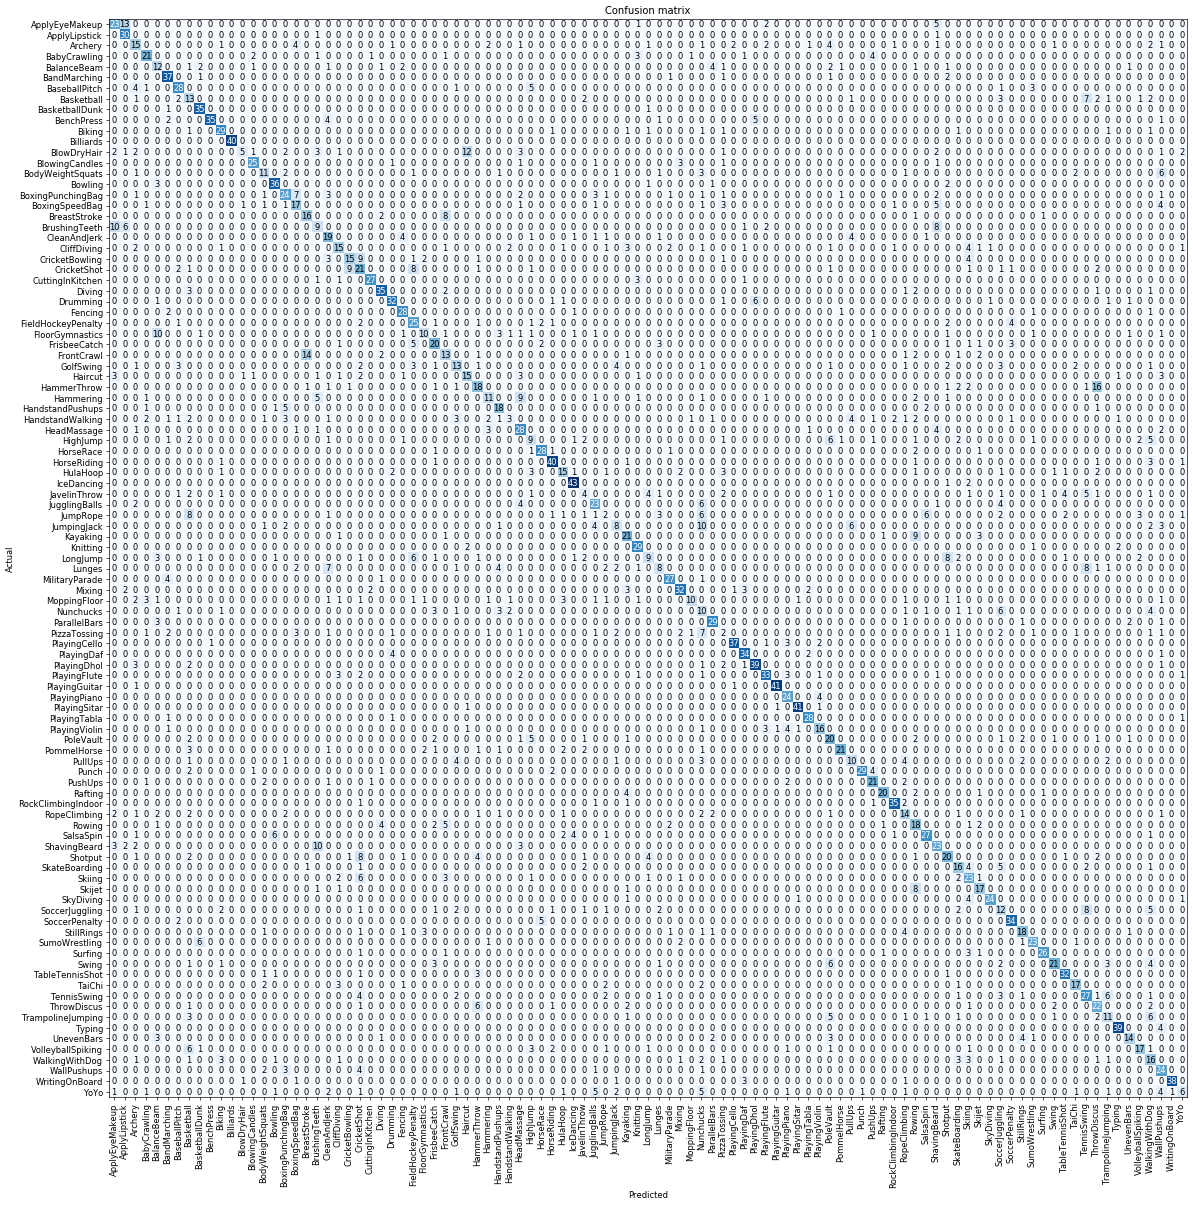

In [ ]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

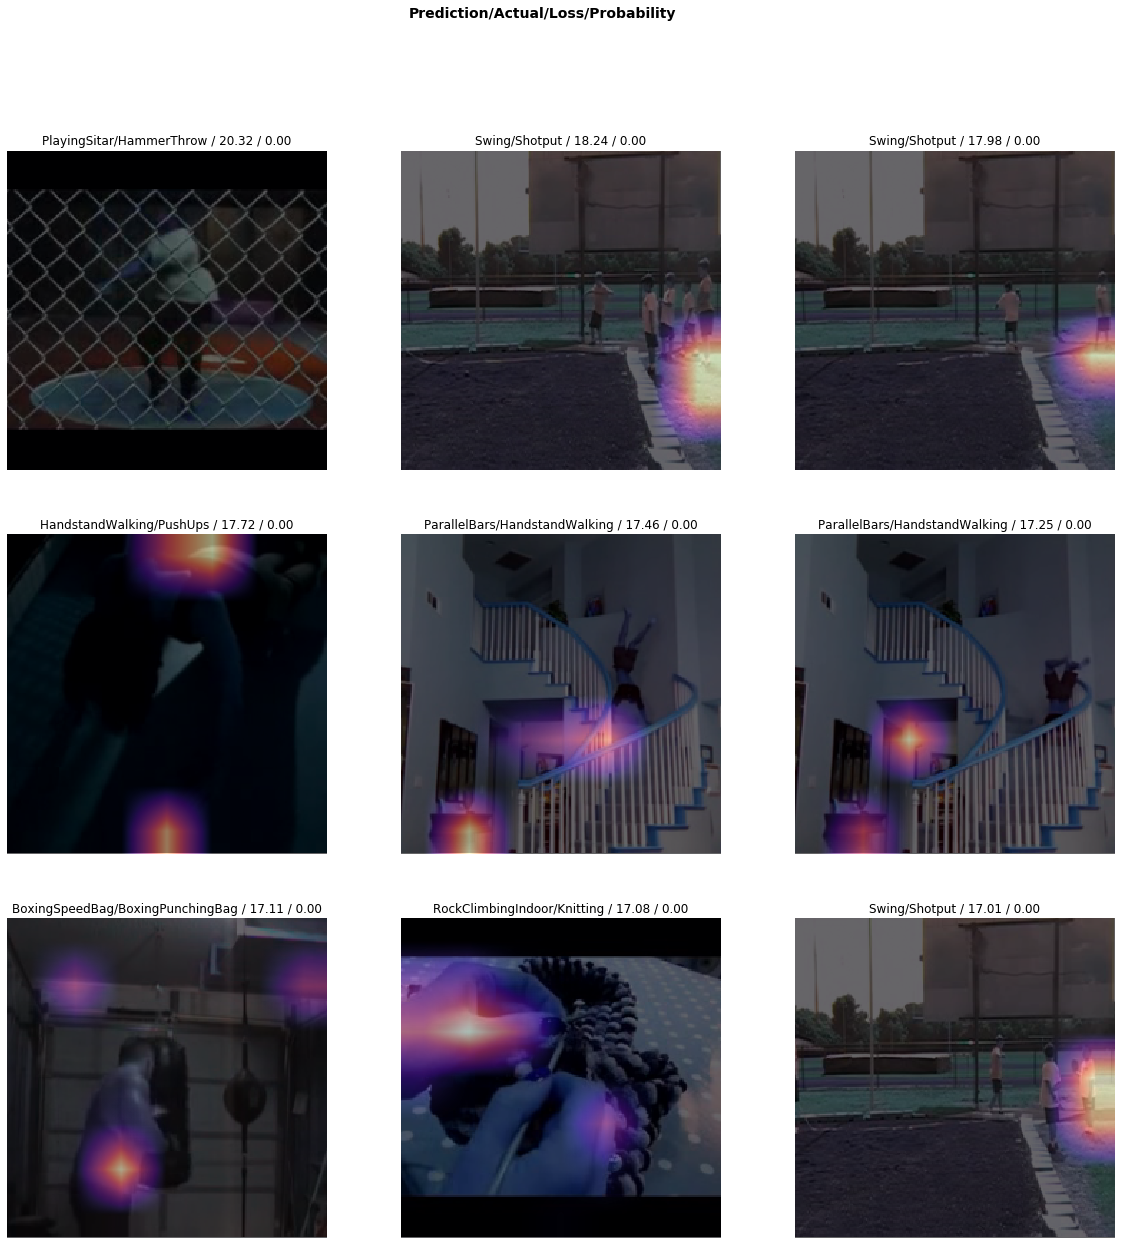

In [ ]:
interp.plot_top_losses(9, figsize=(20,20), heatmap=True)

# Conv3D

In [ ]:
spectral_norm = nn.utils.spectral_norm
weight_norm = nn.utils.weight_norm

In [ ]:
def conv3d(ni:int, nf:int, ks:int=3, stride:int=1, pad:int=1, norm='batch'):
    bias = not norm == 'batch'
    conv = init_default(nn.Conv3d(ni,nf,ks,stride,pad,bias=bias))
    conv = spectral_norm(conv) if norm == 'spectral' else \
           weight_norm(conv) if norm == 'weight' else conv
    layers = [conv]
    layers += [nn.ReLU(inplace=True)]  # use inplace due to memory constraints
    layers += [nn.BatchNorm3d(nf)] if norm == 'batch' else []
    return nn.Sequential(*layers)

def res3d_block(ni, nf, ks=3, norm='batch', dense=False):
    """ 3d Resnet block of `nf` features """
    return SequentialEx(conv3d(ni, nf, ks, pad=ks//2, norm=norm),
                             conv3d(nf, nf, ks, pad=ks//2, norm=norm),
                             MergeLayer(dense))

In [ ]:
norm = 'batch'
layers = ([res3d_block(1,15,7,norm=norm,dense=True)] +
          [res3d_block(16,16,norm=norm) for _ in range(4)] +
          [conv3d(16,1,ks=1,pad=0,norm=None)])
model = nn.Sequential(*layers)

In [ ]:
loss = nn.MSELoss()
learner = Learner(data, model, loss_func=loss)

In [ ]:
learner.lr_find(num_it=50)
learner.recorder.plot()